# Prueba Tecnica LT Challenge

En este notebook, se enfocará en dos enfoques diferentes para cada una de las funciones: tiempo de ejecución y optimización de memoria. Tomaremos q2 (Top 10 de los emojis más usados) como base de nuestra evaluación debido a que la lógica es similar y se repite en todas las funciones. De esta forma, su primera versión servirá para evaluar resultados con las nuevas integraciones. 

Con el objetivo de estructurar este proyecto, el siguiente banco de ideas permite dar un seguimiento a conceptos o tecnologías que podrían ser útiles al proyecto y su estado en la inclusión del mismo:

| Foco            | Concepto                                                         | Estado                           |
|-----------------|------------------------------------------------------------------|----------------------------------|
| tiempo & memoria| **Pandas Basico**: Libreria estandar para procesamiento de datos | Incluida primera version              |
| tiempo & memoria| **Chunks**: Es necesario particionar los datos                   | Incluida primera version              |
| tiempo          | **Multiprocessing**: Procesamiento paralelo                      | Pendiente                        |
| tiempo & meoria | **Polars**: Libreria escrita en Rust                             | Pendiende |
| memoria         | **Generators**: Lazy evaluation e iterators sirven para optimizacion de memoria | Pendiente                        |
| memoria         | **Pandas Avanzado**: Aplicar tecnicas como sparse                | pendiente                        |

Ahora, podemos dar paso al análisis q2

----
## Q2: Análisis top 10 de los emojis más usados en los Tweets

### Preprocesamiento e Importación de Librerías

In [1]:
import pandas as pd
import emoji
import time
import os
from typing import List, Tuple
from memory_profiler import memory_usage
from memory_profiler import profile
import matplotlib.pyplot as plt

In [2]:
from q2_memory import q2_memory
from stats import get_file_path

# Usaremos los datos proveídos en el challenge pero desde google cloud storage
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../sa.json"
bucket_name = 'test_jobs144'
file_name = 'lt/farmers-protest-tweets-2021-2-4.json'
temp_file_path = get_file_path(bucket_name, file_name)

### Estudio Codigo Benchmark (Primera Version)
Este código fue desarrollado de forma básica a los dos días de iniciar el challenge con el fin de tener un punto de referencia. Esta función es igual los dos enfoques por razones de practicidad en el desarrollo del proyecto.

#### Explicacion codigo

In [3]:
%load_ext memory_profiler

@profile
def q2(file_path: str) -> List[Tuple[str, int]]:
    """
    Analyze Twitter data to count emojis for the top 10 emojis.
    
    Args:
    file_path (str): Path to file containing Twitter data.
    
    Returns:
    List[Tuple[str, int]]: Top 10 days with most emojis and their emoji counts
    """
    
    chunks = pd.read_json(file_path, lines=True, chunksize=10000) # Extraemos el archivo y particionamos en particiones de 10000 lineas cada uno
    
    dfs = []
    
    for chunk in chunks: # Por cada chuck (particion) extraemos un dataframe con los emojis y sus contadores
        emojis_list = chunk['content'].apply(extract_emojis).explode() # Extraemos series.pandas continiendo la lista de emojis para luego aplanarlos en una serie de strings 
        emojis_count = emojis_list.to_frame(name='emoji').groupby('emoji').size().reset_index(name='count') # Realizamos conteo por emoji
        dfs.append(emojis_count)
    
    all_counts = pd.concat(dfs) # Concatenamos dataframes derivados de los chunks
    final_counts = all_counts.groupby('emoji')['count'].sum().reset_index() # Realizamos la correspondiente agregacion de acuerdo al emoji
    top_10_days = final_counts.sort_values('count', ascending=False).head(10) # Seleccionamos el top 10
    
    return [(row['emoji'], int(row['count'])) for _, row in top_10_days.iterrows()]

def extract_emojis(text: str) -> list: # Extrae todos los emojis que pueda tener un tweet
    """Get emojis in a given text."""
    return [x for x in text if x in emoji.EMOJI_DATA]

#### Extraemos metricas de uso memoria y tiempo de procesamiento

In [4]:
mem_benchmark_usage = memory_usage((q2, (temp_file_path,), {}))

ERROR: Could not find file /tmp/ipykernel_12845/3316400420.py


In [5]:
print(f"Promedio de memoria usada en benchmark: {sum(mem_benchmark_usage) / len(mem_benchmark_usage)} MiB")
print(f"Maximo de memoria en benchmark: {max(mem_benchmark_usage)} MiB")

Promedio de memoria usada en benchmark: 411.19557045990564 MiB
Maximo de memoria en benchmark: 453.97265625 MiB


In [6]:
start_time = time.time()
exam = q2(temp_file_path)
end_time = time.time()
total_time = end_time - start_time
print(f"Total de tiempo usado en benchmark: {total_time}")

ERROR: Could not find file /tmp/ipykernel_12845/3316400420.py
Total de tiempo usado en benchmark: 10.30360198020935


### Segunda Version
#### Enfoque memoria: Introducimos generators para ver resultados

In [7]:
from typing import List, Tuple, Generator
def q2_mem(file_path: str) -> List[Tuple[str, int]]:
    """
    Analyze Twitter data to count emojis for the top 10 emojis.
    
    Args:
    file_path (str): Path to file containing Twitter data.
    
    Returns:
    List[Tuple[str, int]]: Top 10 emojis with their counts
    """
    
    def process_chunk(chunk: pd.DataFrame) -> pd.DataFrame:
        emojis_series = chunk['content'].apply(extract_emojis).explode() # Intente reducir memoria con sparse o category pero no baja 
        return emojis_series.value_counts().reset_index(name='count')

    def chunk_generator():
        for chunk in pd.read_json(file_path, lines=True, chunksize=4000): # Miminimizamos el numero de lineas en cada batch da resultado
            yield process_chunk(chunk)

    emoji_counts = pd.concat(chunk_generator(), ignore_index=True)
    
    final_counts = emoji_counts.groupby('content')['count'].sum().reset_index()
    top_10_days = final_counts.sort_values('count', ascending=False).head(10)

    return list(zip(top_10_days['content'], top_10_days['count'].astype(int)))


In [8]:
mem_gen_usage = memory_usage((q2_mem, (temp_file_path,), {}))

In [9]:
print(f"Promedio de memoria usada segunda version: {sum(mem_gen_usage) / len(mem_gen_usage)} MiB")
print(f"Maximo de memoria segunda version: {max(mem_gen_usage)} MiB")

Promedio de memoria usada segunda version: 394.3105788934426 MiB
Maximo de memoria segunda version: 400.03515625 MiB


### Evaluacion Resultados de Opmizacion de Memoria

Al observar los resultados del histograma, observamos que el consumo con generators es compacto y menor a comparacion de la primera version del codigo, concluyendo su integracion en el codigo.

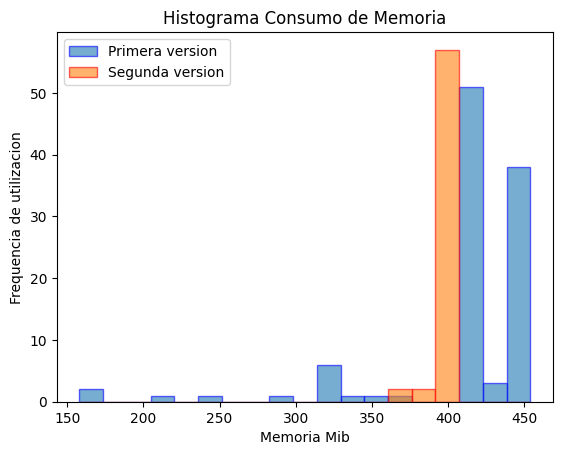

In [10]:
import numpy as np
min_val = min(min(mem_benchmark_usage), min(mem_gen_usage))
max_val = max(max(mem_benchmark_usage), max(mem_gen_usage))
bins = np.linspace(min_val, max_val, 20)
plt.hist(mem_benchmark_usage, bins=bins, edgecolor='blue', alpha=0.6, label='Primera version')
plt.hist(mem_gen_usage, bins=bins, edgecolor='red', alpha=0.6, label='Segunda version')
plt.xlabel('Memoria Mib')
plt.ylabel('Frequencia de utilizacion')
plt.title('Histograma Consumo de Memoria')
plt.legend()
plt.show()

#### Enfoque tiempos de ejecucion: Introducimos multiprocessing para ver resultados

In [13]:
import multiprocessing as mp
from functools import partial

def process_chunk(chunk: pd.DataFrame) -> pd.DataFrame:
    emojis_list = chunk['content'].apply(extract_emojis).explode()
    return emojis_list.to_frame(name='emoji').groupby('emoji').size().reset_index(name='count')

def q2_time(file_path: str) -> List[Tuple[str, int]]:
    """
    Analyze Twitter data to count emojis for the top 10 emojis using multiprocessing.
    
    Args:
    file_path (str): Path to file containing Twitter data.
    
    Returns:
    List[Tuple[str, int]]: Top 10 emojis with most occurrences and their counts
    """
    
    chunks = pd.read_json(file_path, lines=True, chunksize=2000) # Reducimos el tamano de las particiones sin sobrepasarnos para reducir el small file problems
    
    num_cores = mp.cpu_count()
    
    with mp.Pool(num_cores) as pool:
        dfs = pool.map(process_chunk, chunks) #Procesaremos chunks en paralelo
    
    all_counts = pd.concat(dfs)
    final_counts = all_counts.groupby('emoji')['count'].sum().reset_index()
    top_10_days = final_counts.sort_values('count', ascending=False).head(10)
    
    return list(zip(top_10_days['emoji'], top_10_days['count'].astype(int)))

In [14]:
start_time = time.time()
exam = q2_time(temp_file_path)
end_time = time.time()
total_time = end_time - start_time
print(f"Total de tiempo usado en la segunda version: {total_time}")

Total de tiempo usado en la segunda version: 8.558876752853394


#### Como podemos observar se reduce el tiempo de ejecucion con multiprocessing los cuales sera integrados en esta segunda version

----
NOTA: Se evaluo polars pero surgio un bug que en esta entrega no alcanzara el tiempo para ser entregado.

In [15]:
import polars as pl
for i in pl.read_ndjson(temp_file_path, batch_size=10):
    print(i)
    sdf.select(pl.col("content"))

ComputeError: expected null in json value, got object